In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib as mlp
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

In [2]:
from tqdm import tqdm
tqdm.pandas()

/Users/skufeld/miniconda3/envs/data_eng/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [106]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [5]:
base_path = 'raw_data/'

In [751]:

df_airport = pd.read_csv(f"{base_path}airport-codes_csv.csv")
df_temp = pd.read_csv(f'{base_path}GlobalLandTemperaturesByCity.csv')
df_city_demographic = pd.read_csv(f"{base_path}us-cities-demographics.csv",sep=';', delimiter=None)

### Local data structure

In [28]:
! tree raw_data

raw_data
├── GlobalLandTemperaturesByCity.csv
├── I94_SAS_Labels_Descriptions.SAS
├── I94_country_codes.csv
├── I94_port_codes.csv
├── airport-codes_csv.csv
├── immigration
│   ├── i94_apr16_sub.sas7bdat
│   ├── i94_aug16_sub.sas7bdat
│   ├── i94_dec16_sub.sas7bdat
│   ├── i94_feb16_sub.sas7bdat
│   ├── i94_jan16_sub.sas7bdat
│   ├── i94_jul16_sub.sas7bdat
│   ├── i94_jun16_sub.sas7bdat
│   ├── i94_mar16_sub.sas7bdat
│   ├── i94_may16_sub.sas7bdat
│   ├── i94_nov16_sub.sas7bdat
│   ├── i94_oct16_sub.sas7bdat
│   └── i94_sep16_sub.sas7bdat
├── immigration_data_sample.csv
└── us-cities-demographics.csv

1 directory, 19 files


In [11]:
def df_analysis(df, column_name_list):
    result_dict_l1={}
    count=df.shape[0]
    for column_name in column_name_list:
        result_dict_l2={}
        if column_name not in df.columns.tolist():
            print(f"Could not find {column_name} in dataframe")
        result_dict_l2['count']=count
        result_dict_l2['na']=df[column_name].isna().sum()
        if count!=0:
            result_dict_l2['na_percent']=np.divide(result_dict_l2['na']*100,count)
        result_dict_l2['dtype']=df[column_name].dtypes.name
        result_dict_l1[column_name]=result_dict_l2
    return pd.DataFrame(result_dict_l1).T

# Relation between travel, immigration and city demographics in the US 
### Data Engineering Capstone Project

#### Project Summary
The goal of this project is to create a data processing pipeline, that combines data from relevant, **heterogeneous data sources** and exposes this data via a **suitable database & table structure** to data recipients. Those recipients can be data scientists, data analysts as well as decision makers looking at this data through a dashboard. An important facet is to meet the users' expectations of **data quality** and reliability as well as **transparency of the data lineage**. The data processing pipeline can be scheduled to automatically run and update the data basis for the data recipients.      
   
   
- Suitable schema: star schema that separates fact and dimension tables
- Data quality: data quality checks
- Transparent data lineage: DAG visualization in apache airflow
- Heterogeneous data sources: Data from different official sources (temperature, demographic of us cities, immigration data, airport information)


### 1. Project scope and used datasets
At the core of this project is an ELT pipeline, that transforms multiple source datasets step by step into an suitable database structure. The [apache airflow](https://airflow.apache.org/) platform provides many useful features for that, such as automatic scheduling for periodically ingesting new data as well as visualizations and statistics about the pipeline runs. Data quality is addressed by running quality tests already within the pipeline ingestion runs as well as an elaborate database and table design. The final output will be written into [aws redshift](https://docs.aws.amazon.com/redshift/latest/mgmt/welcome.html) tables, that guarantee high availability and fast access times. The data sources are comprised from files of different data formats and volumes. That's why a specialized technology is used to process the data efficiently, namely [apache spark](https://spark.apache.org/), a scalable processing engine. The final data & data structure should be suitable to answer questions about the travel & immigration into the US and it's connection to the city demographics near by. Possible research questions may be:
- What cities are more commonly serve as port of entry? Are those cities different from the rest in terms of their demographic, location etc?
- What are the most common ports of entry per country of origin of the immigrants?
- Is there a connection between the age of immigrants and the age structure of the cities near the port of entry?
- Is there a systematic difference in term of immigration between US states?

The available source data sets, that serve as the data basis for answering all research questions are as follows:

1. Historic temperature data
2. Static airport information
3. Immigration into the us (2016)
4. Demographic of us cities (static)

A short introduction into the datasets will be given below.

##### A) World temperature
The historic temperature dataset provides the daily average temperature (with associated uncertainty) on a per city basis. The earliest record goes back to **1743-11-01** and the most recent record being **2013-09-01**. This dataset tracks a total of 3448 different cities from 159 countries. There are temperature values for **8235082** instances, while **364130** measures are missing.
- Origin: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data
- Structure:| dt | AverageTemperature | AverageTemperatureUncertainty | City | Country | Latitude | Longitude |
- License: CC BY-NC-SA 4.0

In [8]:
df_temp[0:2]

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E

In [12]:
print(f"Min date: {df_temp['dt'].min()} max date:{df_temp['dt'].max()}")

Min date: 1743-11-01 max date:2013-09-01


In [18]:
print(f"Unique cities: {len(df_temp['City'].unique().tolist())} unique countries: {len(df_temp['Country'].unique().tolist())}")

Unique cities: 3448 unique countries: 159


In [19]:
print(f"Number of missing temperature values: {df_temp['AverageTemperature'].isna().sum()}")

Number of missing temperature values: 364130


In [20]:
print(f"Number of valid temperature values: {df_temp['AverageTemperature'].notna().sum()}")

Number of valid temperature values: 8235082


##### B) Airport data 
The airport dataset contains static information about airports, their type (heliport vs airport), the size (i.e. small vs large airport), their location (coordinates, municipality) together with an unique identifier (IATA code). The number of different cities that are covered amount to **27134** in total. The sum of airports described are **55075**.

- The identifier is either the IATA code (3 digits), the ICAO code (4 digits) or if both are not applicable (mostly small airport) the local code
- Origin: https://datahub.io/core/airport-codes#data
- License: Public Domain Dedication and License (PDDL).

In [20]:
df_airport[0:2]

ident           type                  name  elevation_ft continent  \
0   00A       heliport     Total Rf Heliport          11.0       NaN   
1  00AA  small_airport  Aero B Ranch Airport        3435.0       NaN   

  iso_country iso_region municipality gps_code iata_code local_code  \
0          US      US-PA     Bensalem      00A       NaN        00A   
1          US      US-KS        Leoti     00AA       NaN       00AA   

                          coordinates  
0  -74.93360137939453, 40.07080078125  
1              -101.473911, 38.704022

| Airport types    	|
|---------------	|
| heliport      	|
| small_airport 	|
| closed        	|
| seaplane_base 	|
| balloonport 	    |
| medium_airport 	|
| large_airport 	|

In [37]:
print(f"Unique municipalities: {len(df_airport['municipality'].unique().tolist())}")

Unique municipalities: 27134


In [38]:
print(f"Unique identifiers: {len(df_airport['ident'].unique().tolist())}")

Unique identifiers: 55075


In [39]:
print(f"Number of missing identifiers: {df_airport['ident'].isna().sum()}")

Number of missing identifiers: 0


In [40]:
print(f"Number of valid identifiers: {df_airport['ident'].notna().sum()}")

Number of valid identifiers: 55075


##### C) Immigration data

Out of the four datasets, the immigration dataset is by far the biggest, it is divided into 12 files (one month each) with 28 columns and 40.790.529 rows combined. It contains information about immigeration, gathered by the US national travel and tourism office for the year 2016. It contains information about international visitors arriving to the USA such as country of origin, type of visa, mode of transportation, age group, states visited (first intended address only), and the port of entry.
- Origin: https://travel.trade.gov/research/reports/i94/historical/2016.html
- License: National Travel and Tourism Office (NTTO)   

Find an excerpt of the columns below:

In [ ]:
- Month and YTD of arrivals
- Type of visa (business, pleasure, student)
- Mode of transportation (air, land, sea)
- Age of traveler (7 age groupings, mean and median)
- First Intended Address in the U.S. (or Address while in the U.S.) (state)
- U.S. port of entry (main gateway ports - all modes and air-only)

Importand columns:
'i94yr',
'i94mon'
'i94cit',
'i94port',
'count',
'i94visa',
'visatype'
 
 value i94model
	1 = 'Air'
	2 = 'Sea'
	3 = 'Land'
	9 = 'Not reported' ;
/* I94BIR - Age of Respondent in Years */


/* I94VISA - Visa codes collapsed into three categories:
   1 = Business
   2 = Pleasure
   3 = Student
*/

In [4]:
df_immigration[0:4]

Unnamed: 0      cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  \
0     2027561  4084316.0  2016.0     4.0   209.0   209.0     HHW  20566.0   
1     2171295  4422636.0  2016.0     4.0   582.0   582.0     MCA  20567.0   
2      589494  1195600.0  2016.0     4.0   148.0   112.0     OGG  20551.0   
3     2631158  5291768.0  2016.0     4.0   297.0   297.0     LOS  20572.0   

   i94mode i94addr    ...     entdepu  matflag  biryear   dtaddto  gender  \
0      1.0      HI    ...         NaN        M   1955.0  07202016       F   
1      1.0      TX    ...         NaN        M   1990.0  10222016       M   
2      1.0      FL    ...         NaN        M   1940.0  07052016       M   
3      1.0      CA    ...         NaN        M   1991.0  10272016       M   

  insnum airline        admnum  fltno  visatype  
0    NaN      JL  5.658267e+10  00782        WT  
1    NaN     *GA  9.436200e+10  XBLNG        B2  
2    NaN      LH  5.578047e+10  00464        WT  
3    NaN      QR  9.478970e+10  00739        B2  

[4 rows x 29 columns]

In [45]:
print("Files are listed below:")

Files are listed below:


In [5]:
! ls immigration

i94_apr16_sub.sas7bdat i94_jan16_sub.sas7bdat i94_may16_sub.sas7bdat
i94_aug16_sub.sas7bdat i94_jul16_sub.sas7bdat i94_nov16_sub.sas7bdat
i94_dec16_sub.sas7bdat i94_jun16_sub.sas7bdat i94_oct16_sub.sas7bdat
i94_feb16_sub.sas7bdat i94_mar16_sub.sas7bdat i94_sep16_sub.sas7bdat


##### D) US city demographic
The city demographic dataset contains demographics information of all US cities with a population greater or equal to **65,000** inhabitans. It is based on a community survey from the US Census Bureau from **2015**. This dataset covers a total of 567 cities in 49 US states and contains information such as the median age, total population (split by male/female), average household size and the number of foreign-born inhabitants. Additionally it provides the number of inhabitants of specific racial groups.

- Origin: https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/
- Publisher: [U.S. Census Bureau](https://www.census.gov/data/developers/about/terms-of-service.html)
- License: Public domain

In [47]:
df_city_demographic[0:4]

City          State  Median Age  Male Population  \
0     Silver Spring       Maryland        33.8          40601.0   
1            Quincy  Massachusetts        41.0          44129.0   
2            Hoover        Alabama        38.5          38040.0   
3  Rancho Cucamonga     California        34.5          88127.0   

   Female Population  Total Population  Number of Veterans  Foreign-born  \
0            41862.0             82463              1562.0       30908.0   
1            49500.0             93629              4147.0       32935.0   
2            46799.0             84839              4819.0        8229.0   
3            87105.0            175232              5821.0       33878.0   

   Average Household Size State Code                       Race  Count  
0                    2.60         MD         Hispanic or Latino  25924  
1                    2.39         MA                      White  58723  
2                    2.58         AL                      Asian   4759  
3                    3.18         CA  Black or African-American  24437

In [63]:
states=len(df_city_demographic['State'].unique().tolist())
print(f"Number of unique states: {states}")

Number of unique states: 49


In [66]:
cities=len(df_city_demographic['City'].unique().tolist())
print(f"Number of unique cities: {cities}")

Number of unique cities: 567


In [65]:
race_categories=len(df_city_demographic['Race'].unique().tolist())
print(f"Number of race categories: {race_categories}")

Number of race categories: 5


### 2. Data exploration and evaluation
In this paragraph an extensive analysis of all four data sets is conducted. This includes an exploration of the columns and their types, their unique values as well as data quality considerations, i.e. missing/duplicate values.

##### A) World temperature
Data exploration:  
- Prepare data for analysis
- List column data types and cast values if necessary
- Define transformation functions when needed  

Data evaluation:  
- Inspect data quality issues, i.e. missing values
- Explore value distributions
- Choose useful informations/columns

In [11]:
df_temp.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                              object
Country                           object
Latitude                          object
Longitude                         object
dtype: object

##### Data Types
- Date column 'dt' is of type string and needs to be transformed to date type
- Columns 'Latitude' & 'Longitude' are both of the string and need to be transformed into floating types

In [69]:
df_temp[0:2]

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
1  1743-12-01                 NaN                            NaN  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
1  Denmark   57.05N    10.33E

In [70]:
df_temp['dt']=pd.to_datetime(df_temp['dt'], format='%Y-%m-%d',)

In [73]:
df_temp.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In the geographic coordinate system, North-South and East-West directions are encoded as signs.   
North and East are assigned a positive (+) sign and South and West are assigned a negative (-) sign.

In [25]:
def lat_long_tranform(lat_or_long_string):
    suffix = lat_or_long_string[-1]
    coordinate = lat_or_long_string[0:-1]
    if suffix in ['S', 'W']:
        return float(coordinate)*(-1)
    else:
        return float(coordinate)

In [26]:
df_temp['Longitude'] = df_temp.apply(lambda row: lat_long_tranform(row['Longitude']),
                                    axis=1)

In [27]:
df_temp['Latitude'] = df_temp.apply(lambda row: lat_long_tranform(row['Latitude']),
                                    axis=1)

In [102]:
df_temp[0:2]

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0 1743-11-01               6.068                          1.737  Århus   
1 1743-12-01                 NaN                            NaN  Århus   

   Country  Latitude  Longitude  
0  Denmark     57.05      10.33  
1  Denmark     57.05      10.33

In [109]:
temp_analysis = df_analysis(df_temp, df_temp.columns.tolist())

In [110]:
temp_analysis

count      na na_percent           dtype
dt                             8599212       0          0  datetime64[ns]
AverageTemperature             8599212  364130    4.23446         float64
AverageTemperatureUncertainty  8599212  364130    4.23446         float64
City                           8599212       0          0          object
Country                        8599212       0          0          object
Latitude                       8599212       0          0         float64
Longitude                      8599212       0          0         float64

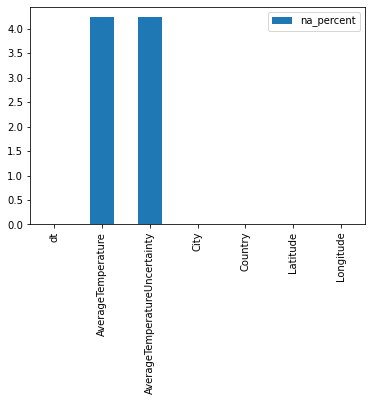

In [111]:
_ = temp_analysis[['na_percent']].plot.bar()

#### Missing values are present only in the temperature columns.
About 4% of values are missing, which is certainly below any criticality.  

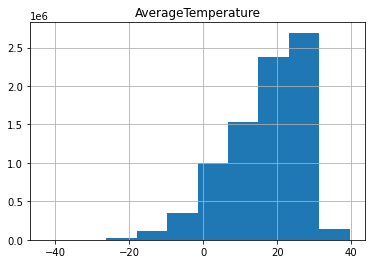

In [113]:
_ = df_temp.hist('AverageTemperature')

In [114]:
df_temp_augmented = df_temp.copy()

In [115]:
df_temp_augmented['year'] = pd.DatetimeIndex(df_temp_augmented['dt']).year

In [116]:
len(df_temp_augmented['year'].unique()), df_temp_augmented['year'].max()

(271, 2013)

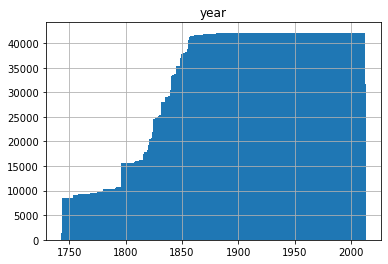

In [117]:
_ = df_temp_augmented.hist('year', bins=271)

### From the year 1875 upwards the number of data points per year is consistently around 41k
- The earliest record starts at about 1740
- The latest data points are from the year 2013

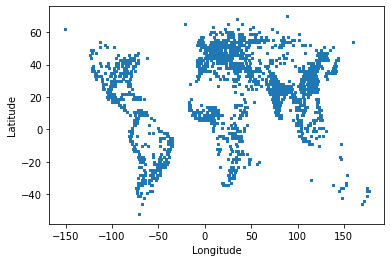

In [31]:
_ = df_temp.plot.scatter(x='Longitude',y='Latitude',s=1)

The plot of the lat & long coordinates resembles the world map with it's continents. This confirms, that the data is correct in this regard.

##### B) Airport codes
Data exploration:  
- Prepare data for analysis
- List column data types and cast values if necessary
- Define transformation functions when needed  

Data evaluation:  
- Inspect data quality issues, i.e. missing values
- Explore value distributions
- Choose useful informations/columns

In [3]:
df_airport = pd.read_csv("airport-codes_csv.csv")

In [4]:
df_airport[0:2]

ident           type                  name  elevation_ft continent  \
0   00A       heliport     Total Rf Heliport          11.0       NaN   
1  00AA  small_airport  Aero B Ranch Airport        3435.0       NaN   

  iso_country iso_region municipality gps_code iata_code local_code  \
0          US      US-PA     Bensalem      00A       NaN        00A   
1          US      US-KS        Leoti     00AA       NaN       00AA   

                          coordinates  
0  -74.93360137939453, 40.07080078125  
1              -101.473911, 38.704022

In [6]:
df_airport.dtypes

ident            object
type             object
name             object
elevation_ft    float64
continent        object
iso_country      object
iso_region       object
municipality     object
gps_code         object
iata_code        object
local_code       object
coordinates      object
dtype: object

The coodinates column is of type string and contains the comma separated latitude and longitude information. Here the convention is latitude first and longitude second, but exceptions are often encountered.   

Further reading: http://docs.geotools.org/latest/userguide/library/referencing/order.html

In [48]:
def return_lat_long(string, order=True):
    lat_long_tuple = string.split(',')
    try:
        first=np.float64(lat_long_tuple[0].strip())
        second=np.float64(lat_long_tuple[1].strip())
    except ValueError:
        first=np.nan
        second=np.nan
    if order:
        return first, second
    else:
        return second, first

In [49]:
df_airport['lat'], df_airport['long'] = zip(*df_airport['coordinates'].apply(return_lat_long,True))

KeyError: 'coordinates'

In [7]:
df_airport[0:3]

ident           type                  name  elevation_ft continent  \
0   00A       heliport     Total Rf Heliport          11.0       NaN   
1  00AA  small_airport  Aero B Ranch Airport        3435.0       NaN   
2  00AK  small_airport          Lowell Field         450.0       NaN   

  iso_country iso_region  municipality gps_code iata_code local_code  \
0          US      US-PA      Bensalem      00A       NaN        00A   
1          US      US-KS         Leoti     00AA       NaN       00AA   
2          US      US-AK  Anchor Point     00AK       NaN       00AK   

                          coordinates         lat       long  
0  -74.93360137939453, 40.07080078125  -74.933601  40.070801  
1              -101.473911, 38.704022 -101.473911  38.704022  
2         -151.695999146, 59.94919968 -151.695999  59.949200

In [12]:
airport_analysis = df_analysis(df_airport, df_airport.columns.tolist())

In [13]:
airport_analysis

count     na na_percent    dtype
ident         55075      0          0   object
type          55075      0          0   object
name          55075      0          0   object
elevation_ft  55075   7006    12.7208  float64
continent     55075  27719    50.3296   object
iso_country   55075    247   0.448479   object
iso_region    55075      0          0   object
municipality  55075   5676    10.3059   object
gps_code      55075  14045    25.5016   object
iata_code     55075  45886    83.3155   object
local_code    55075  26389    47.9147   object
lat           55075      0          0  float64
long          55075      0          0  float64

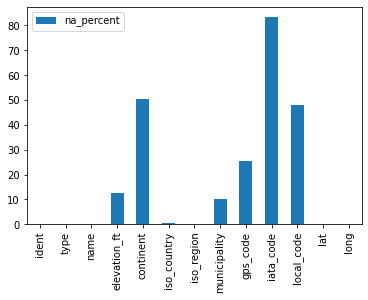

In [14]:
_ = airport_analysis[['na_percent']].plot.bar()

- Missing values make up 80% of all IATA code information in this dataset
- An alternative to the IATA code, the gps code (ICAO), is missing about 30% of values
- There is alway an identifier available (either IATA, ICAO or local code)
- The continent information is missing in about 50% of the time
- Since geographic coordinates are always present, the location of an airport can always be precisely inferred

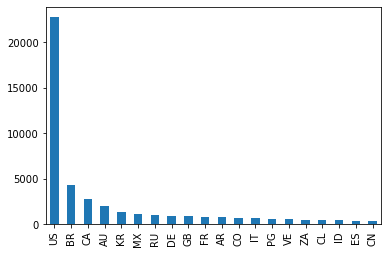

In [15]:
_ = df_airport['iso_country'].value_counts()[0:20].plot(kind='bar')

In [108]:
len(df_airport['iso_country'].unique())

244

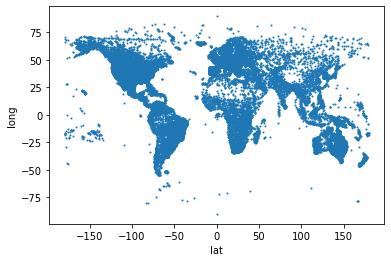

In [51]:
_ = df_airport.plot.scatter(x='lat', y='long',s=1)

This plot of the latitude & longitude clearly resembles a world map as the outlines of the continents are easy to see. One incorrectness is that the axes are switches, i.e. latitude and longitued need to be swapped. This can be achieved by applying the **return_lat_long** function with the **order** argument set to **False**.

##### C) City demographics
Data exploration:  
- Prepare data for analysis
- List column data types and cast values if necessary
- Define transformation functions when needed  

Data evaluation:  
- Inspect data quality issues, i.e. missing values
- Explore value distributions
- Choose useful informations/columns

In [52]:
df_city_demographic = pd.read_csv("us-cities-demographics.csv",sep=';', delimiter=None)

In [53]:
df_city_demographic.dtypes

City                       object
State                      object
Median Age                float64
Male Population           float64
Female Population         float64
Total Population            int64
Number of Veterans        float64
Foreign-born              float64
Average Household Size    float64
State Code                 object
Race                       object
Count                       int64
dtype: object

All column types are already set correctly.

In [54]:
df_city_demographic[0:3]

City          State  Median Age  Male Population  \
0  Silver Spring       Maryland        33.8          40601.0   
1         Quincy  Massachusetts        41.0          44129.0   
2         Hoover        Alabama        38.5          38040.0   

   Female Population  Total Population  Number of Veterans  Foreign-born  \
0            41862.0             82463              1562.0       30908.0   
1            49500.0             93629              4147.0       32935.0   
2            46799.0             84839              4819.0        8229.0   

   Average Household Size State Code                Race  Count  
0                    2.60         MD  Hispanic or Latino  25924  
1                    2.39         MA               White  58723  
2                    2.58         AL               Asian   4759

In [55]:
city_analysis = df_analysis(df_city_demographic, df_city_demographic.columns.tolist())

In [56]:
city_analysis

count  na na_percent    dtype
City                    2891   0          0   object
State                   2891   0          0   object
Median Age              2891   0          0  float64
Male Population         2891   3    0.10377  float64
Female Population       2891   3    0.10377  float64
Total Population        2891   0          0    int64
Number of Veterans      2891  13   0.449671  float64
Foreign-born            2891  13   0.449671  float64
Average Household Size  2891  16   0.553442  float64
State Code              2891   0          0   object
Race                    2891   0          0   object
Count                   2891   0          0    int64

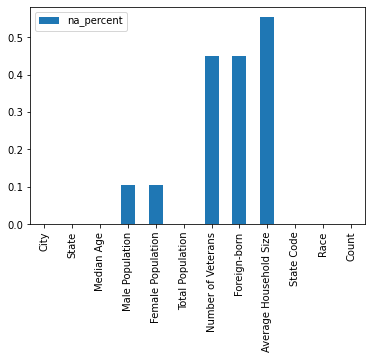

In [57]:
_ = city_analysis[['na_percent']].plot.bar()

From the plot above one can see that 5 columns out of 12 contain missing values. The extend of unavailable values is comparibly low, with the highest amount of about only 0.5%. 

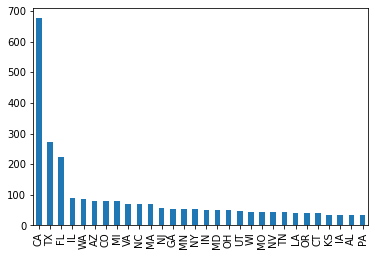

In [60]:
_ = df_city_demographic['State Code'].value_counts()[0:30].plot(kind='bar')

The most frequent occurring US state in this dataset is by far california (CA), with about 700 occurrences. The distribution is mostly flat with the majority of US states occurring around 50-100 times.

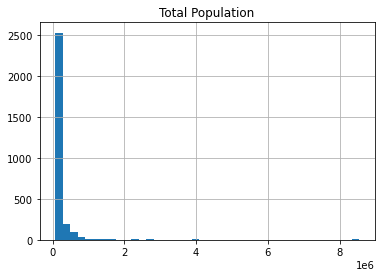

In [65]:
_ = df_city_demographic.hist('Total Population', bins=40)

The vast majority of the municipalities/cities in this dataset have a total population of 1 million or below.

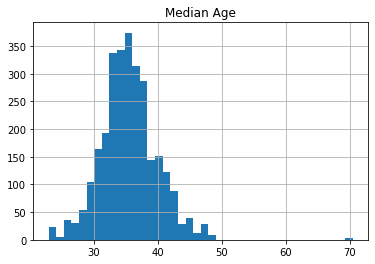

In [67]:
_ = df_city_demographic.hist('Median Age', bins=40)

The most frequent median age within the cities in this dataset is 35. The distribution is symmetric around it's mode.

##### C) US immigration data
Data exploration:  
- Prepare data for analysis
- List column data types and cast values if necessary
- Define transformation functions when needed  

Data evaluation:  
- Inspect data quality issues, i.e. missing values
- Explore value distributions
- Choose useful informations/columns

In [2]:
from pyspark.sql import DataFrame 

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
path=f"{base_path}immigration/"
file_1="i94_apr16_sub.sas7bdat"
file_2="i94_jan16_sub.sas7bdat"
file_3="i94_may16_sub.sas7bdat"
file_4="i94_aug16_sub.sas7bdat"
file_5="i94_jul16_sub.sas7bdat"
file_6="i94_nov16_sub.sas7bdat"
file_7="i94_dec16_sub.sas7bdat"
file_8="i94_jun16_sub.sas7bdat"
file_9="i94_oct16_sub.sas7bdat"
file_10="i94_feb16_sub.sas7bdat"
file_11="i94_mar16_sub.sas7bdat"
file_12="i94_sep16_sub.sas7bdat"
file_list = [file_1, file_2, file_3, file_4, file_5, file_6, file_7, file_8, file_9, file_10, file_11, file_12]
df_list=[]
for file in file_list:
    df_list.append((spark.read.format('com.github.saurfang.sas.spark').load(f"{path}{file}")))

In [73]:
total_count=0
for i,df in enumerate(df_list):
    c=df.count()
    total_count=total_count+c
    print(f"{i}: columns:{len(df.columns)}, counts:{c}")
print(f"total count:{total_count}")

0: columns:28, counts:3096313
1: columns:28, counts:2847924
2: columns:28, counts:3444249
3: columns:28, counts:4103570
4: columns:28, counts:4265031
5: columns:28, counts:2914926
6: columns:28, counts:3432990
7: columns:34, counts:3574989
8: columns:28, counts:3649136
9: columns:28, counts:2570543
10: columns:28, counts:3157072
11: columns:28, counts:3733786
total count:40790529


The US immigration dataset is split into **12 sas files**, each of which contains the data for one of **12 months** of the year **2016**. With over 4 million rows, this is a comparibly large dataset. There are 28 columns in each of the files with the exception of the november dataset, which contains 34 columns.

In [7]:
column_list = df_list[0].columns

In [8]:
df_list = [df.select(column_list) for df in df_list]

In [9]:
from functools import reduce
df = reduce(DataFrame.unionAll, df_list)

In [10]:
df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

First analyse column `cicid` which can potentially serve as an unique identifier.

In [769]:
df.select(col('cicid')).distinct().count()

7380352

Values are not unique within the dataset.

In [15]:
df.select(col('cicid')).groupBy(col('cicid')).count().filter("count > 1").orderBy('count', ascending=False).toPandas()

cicid  count
0          55288.0     12
1          55791.0     12
2          63867.0     12
3          67066.0     12
4          67934.0     12
...            ...    ...
6929792  6657186.0      2
6929793  6661931.0      2
6929794  6666145.0      2
6929795  6670812.0      2
6929796  6557426.0      2

[6929797 rows x 2 columns]

There are at most 12 duplicates of any `cicid` within the data set.

In [18]:
df.select('*').where(col('cicid') == 55288.0).toPandas()

cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  \
0   55288.0  2016.0     4.0   209.0   209.0     HHW  20545.0      1.0      HI   
1   55288.0  2016.0     1.0   245.0   245.0     SEA  20457.0      1.0      TN   
2   55288.0  2016.0     5.0   209.0   209.0     HHW  20575.0      1.0      HI   
3   55288.0  2016.0     8.0   209.0   209.0     POO  20667.0      1.0      OR   
4   55288.0  2016.0     7.0   438.0   438.0     LOS  20636.0      1.0      MA   
5   55288.0  2016.0    11.0   209.0   209.0     HHW  20759.0      1.0    None   
6   55288.0  2016.0    12.0   582.0   582.0     HOU  20789.0      1.0      MA   
7   55288.0  2016.0     6.0   209.0   209.0     NYC  20606.0      1.0      NY   
8   55288.0  2016.0    10.0   148.0   112.0     BOS  20728.0      1.0      MA   
9   55288.0  2016.0     2.0   582.0   582.0     DAL  20489.0      1.0      MI   
10  55288.0  2016.0     3.0   251.0   251.0     NYC  20514.0      1.0      MI   
11  55288.0  2016.0     9.0   687.0   687.0     MIA  20698.0      1.0      FL   

    depdate  ...  entdepu  matflag  biryear   dtaddto gender  insnum airline  \
0   20549.0  ...     None        M   1957.0  06292016      M    None      DL   
1       NaN  ...     None     None   1999.0       D/S      M    None      DL   
2   20580.0  ...     None        M   2015.0  07292016      M    None      JL   
3   20672.0  ...     None        M   2003.0  10292016      M  131751      DL   
4   20646.0  ...     None        M   1983.0  09282016   None    None      DL   
5   20761.0  ...     None        M   1986.0  01292017   None    None      JL   
6   20800.0  ...     None        M   1995.0  05312017      M   14844      UA   
7   20609.0  ...     None        M   1979.0  08292016      M    None      JL   
8   20741.0  ...     None        M   1964.0  12292016      M    None      LH   
9   20496.0  ...     None        M   1984.0  08042016      M    None      AA   
10  20680.0  ...     None        M   1947.0  08312016      F    None      DL   
11  20708.0  ...     None        M   1970.0  02282017      M    None      4M   

          admnum  fltno visatype  
0   5.541625e+10  00612       WT  
1   2.975703e+08    128       F1  
2   5.961558e+10  00792       WT  
3   4.424702e+09    622       WT  
4   6.304852e+10  00040       WB  
5   6.748535e+10  08782       WB  
6   1.529260e+10    428       B2  
7   6.129373e+10  00006       WT  
8   6.543561e+10  00422       WT  
9   4.592731e+08    387       B2  
10  8.942078e+10  00408       B2  
11  8.303811e+09   4520       B2  

[12 rows x 28 columns]

The `cicid` seems to be unique within each month, indicated by the `i94mon` column.

In [770]:
df.select(col('cicid')).dropna().count()

40790529

In [19]:
df.select(col('i94mon')).dropna().count()

40790529

In [22]:
from pyspark.sql.functions import countDistinct

In [25]:
df.agg(countDistinct(col('cicid'),col('i94mon')).alias("count")).show()

+--------+
|   count|
+--------+
|40790529|
+--------+



The `cicid` is an unique identifier, within each month's data subset. The combination of `cicid` and `i94mon` is suitbale as an ID or primary key, since it is never missing and always unique.

Since the dataset is quite large, it makes sense to sample it, before continuing with the analysis an the entirety of the columns.

In [89]:
df_immigration = df.sample(withReplacement=True, fraction=0.05, seed=1).toPandas()

In [107]:
df_immigration[0:3]

cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  depdate  i94bir  i94visa  count  dtadfile visapost occup entdepa entdepd entdepu matflag  biryear   dtaddto gender insnum airline        admnum  fltno visatype
0   24.0  2016.0     4.0   101.0   101.0     TOR  20545.0      1.0      MO  20554.0    33.0      2.0    1.0  20160401     None  None       O       O    None       M   1983.0  09302016   None   None      MQ  9.249091e+10  03348       B2
1  142.0  2016.0     4.0   103.0   103.0     NEW  20545.0      1.0      NY  20550.0    29.0      1.0    1.0  20160401     None  None       G       O    None       M   1987.0  06292016      M   None      UA  5.546127e+10  01066       WB
2  152.0  2016.0     4.0   103.0   103.0     NEW  20545.0      1.0      NY  20553.0    48.0      2.0    1.0  20160401     None  None       G       O    None       M   1968.0  06292016      F   None      OS  5.542222e+10  00089       WT

In [91]:
del df_list, df

In [92]:
immigration_analysis = df_analysis(df_immigration, df_immigration.columns.tolist())

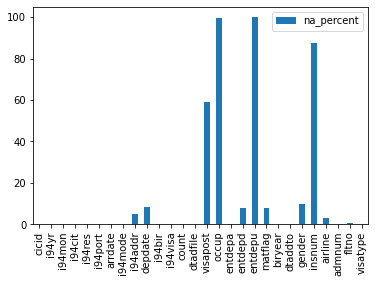

In [98]:
_ = immigration_analysis[['na_percent']].plot.bar()

Most notebly, there are 2 columns those values are missing entirely in this sample (occup & entdepu) and 2 columns with the majority of values missing: visapost & insnum. With the exception of this columns, missing values are no more common than 10% of the time.

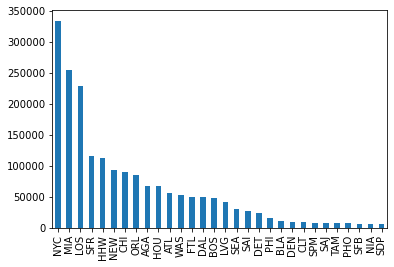

In [110]:
_ = df_immigration['i94port'].value_counts()[0:30].plot(kind='bar')

New york city is the most common port of arrival into the US in 2016. 

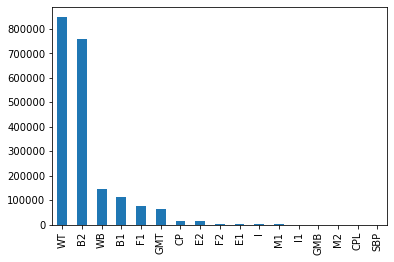

In [111]:
_ = df_immigration['visatype'].value_counts()[0:30].plot(kind='bar')

The 2 most commonly used visa for entry are **WT & B2, which are non-immigrant categories for short term visits** such as tourism, vacation.
The second-most frequent category is the **non-immigrant business visa (WB & B1)**.
A comprehensible mapping of visa to it's associated immigration status can be found below.

Sources:
https://visaservices.duke.edu/categories/b2-wt
https://travel.trade.gov/research/programs/i94/methodology.asp
https://en.wikipedia.org/wiki/I-1_visa
https://travel.state.gov/content/travel/en/us-visas/visa-information-resources/all-visa-categories.html
https://www.ice.gov/doclib/human-trafficking/pdf/continued-presence.pdf

In [114]:
visa_mapping =  {'B2':'nonimmigrant',
                 'WB':'nonimmigrant',
                 'WT':'nonimmigrant',
                 'B1':'nonimmigrant',
                 'E2':'immigrant',
                 'I1':'nonimmigrant',
                 'F1':'immigrant',
                 'I':'nonimmigrant',
                 'E1':'immigrant',
                 'CP':'immigrant',
                 'F2':'immigrant',
                 'M2':'nonimmigrant',
                 'M1':'nonimmigrant',
                 'CPL':'nonimmigrant',
                 'GMT':'nonimmigrant',
                 'GMB':'nonimmigrant',
                 'SBP':'nonimmigrant',}
visa_mapping

{'B2': 'nonimmigrant',
 'WB': 'nonimmigrant',
 'WT': 'nonimmigrant',
 'B1': 'nonimmigrant',
 'E2': 'immigrant',
 'I1': 'nonimmigrant',
 'F1': 'immigrant',
 'I': 'nonimmigrant',
 'E1': 'immigrant',
 'CP': 'immigrant',
 'F2': 'immigrant',
 'M2': 'nonimmigrant',
 'M1': 'nonimmigrant',
 'CPL': 'nonimmigrant',
 'GMT': 'nonimmigrant',
 'GMB': 'nonimmigrant',
 'SBP': 'nonimmigrant'}

The adjecent file `I94_SAS_Labels_Descriptions.SAS` contains additional context information, that will be useful to include also in the final table structure.

In [118]:
I94_label_descriptions_file = open('I94_SAS_Labels_Descriptions.SAS', 'r') 
I94_label_descriptions = I94_label_descriptions_file.readlines() 
I94_label_descriptions_file.close() 

In [154]:
def txt_to_dict(text_lines):
    d={}
    for row, line in enumerate(text_lines):
        pattern = "\s+|\;+|\'+"
        text_cleaned = re.sub(pattern,'',line)
        try:
            k, v = text_cleaned.split('=')
        except ValueError:
            print(f"Row {row} could not be split by equal sign. Line: {line}")
        if k in d.keys():
            print(f"Overwriting key (k)")
        d[k] = v
    return d

In [155]:
I94_country_codes = txt_to_dict(I94_label_descriptions[9:297])

In [183]:
df_I94_country_codes = pd.DataFrame(I94_country_codes.items(), columns=['i94cit','country'])

In [212]:
df_I94_country_codes[0:10]

i94cit                                           country
0    582  MEXICOAirSea,andNotReported(I-94,nolandarrivals)
1    236                                       AFGHANISTAN
2    101                                           ALBANIA
3    316                                           ALGERIA
4    102                                           ANDORRA
5    324                                            ANGOLA
6    529                                          ANGUILLA
7    518                                   ANTIGUA-BARBUDA
8    687                                         ARGENTINA
9    151                                           ARMENIA

`df_I94_country_codes` contains the mapping information from the country code (column i94cit) to the full country name. This relation will be saved as a coma separated file and later ingested within the data pipeline.

In [185]:
df_I94_country_codes.to_csv('I94_country_codes.csv')

In [161]:
I94_port_codes = txt_to_dict(I94_label_descriptions[302:961])

In [186]:
df_I94_port_codes = pd.DataFrame(I94_port_codes.items(), columns=['i94port','airport'])

In [187]:
df_I94_port_codes[0:3]

i94port                  airport
0     ALC                 ALCAN,AK
1     ANC             ANCHORAGE,AK
2     BAR  BAKERAAF-BAKERISLAND,AK

`df_I94_port_codes` contains the mapping information from the IATA airport code (column i94port) to the full airport name. This relation will also be saved as a coma separated file and later ingested within the data pipeline.

In [188]:
df_I94_port_codes.to_csv('I94_port_codes.csv')

In [ ]:
I94_port_time = txt_to_dict(I94_label_descriptions[302:961])

In [ ]:
df.describe('uniform', 'normal').show()
df.summary()

In [ ]:
freq = df.stat.freqItems(["a", "b", "c"], 0.4)
freq.collect()[0]

### Step 3: Data model
#### Conceptual data model
Data model and schema considerations:
- The **target data model** of this data processing pipeline is the **star schema**. This is a simple database structure that divides the data into **one fact table** and **multiple dimension tables**. The **fact table** is typically information that is at the **core of the research** question and **grows necessarily as the observation continues**. **Dimensional tables** on the other hand offer **context information** that can be joined with the data in the fact table. Those tables **don't necessary grow with additional observations**. Also those tables should be **deduplicated**, which is **not true for fact tables**, since the latter contain **transactional data**. To realize this described data structure, data from all data source potentially have to rearrangened, a process which typically includes joining, filtering and deduplicating the data. This makes it necessary to load the data sources/files into so called **staging tables**. This tables **closely resemble the source data**, which additionaly constrains such as **unique primary keys** and **constant data types** within a given column.      

Pipeline considerations:
- In this specific case of data, some custom transformations are necessary to be able to extract important information from the data files at hand. One example for this is extraction of latitude and longitude values from **coordinates** column in the **airport-codes_csv.csv** file which combines both values into a single string. That is the reason why the first step in the processing of the data is a transformation of each data source with pyspark. The data is later saved to parquet format, which is a suitable data format in case the data scales up in the future. This process has the additional benefits that filtering and deduplication is done before the data is uploaded to S3 buckets on AWS to be later loaded into staging tables. Although for practicality reasons, the pyspark instance is spun up locally, this can be adapted to be outsourced to AWS' EMR instances for seamless scaling.

Data scope considerations:
- From the data analysis point of view, the world temperature does not provide much value as an dimensional table for enriching the immigration data. The main value of the world temperature dataset is the evolution of temperature over a long time range, but the remaining datasets either represent static information or only one year of transactional data. Based on the immigration data, all analyses can only be performed for the year 2016 and an additional dimension with only one data point (temperature in the year 2016 for every city) won't be nearly enough to draw conclusion from it. Consequently, the world temperature data set will be excluded in the data processing pipeline.

#### Mapping out data pipelines
Overview of the data processing steps:   

    1. Load each data source into pyspark (filter, deduplicate, cast types and apply custom transformations, save to parquet files)
    2. Upload the entire resulting data structure to the target AWS S3 bucket
    3. Load parquet files into separate staging tables (AWS redshift) per data source
    4. Perform a data quality analysis to verify that the data is successfully loaded into the staging tables
    5. Perform SQL queries to insert data to the desired star schema from the staging tables
    6. Perform a data quality analysis of final tables

Outline step 1 below
- Pyspark preprocessing

#### 1. A) I94 immigration data

In [ ]:
column_list = ['cicid', 'i94cit', 'i94port', 'arrdate',
               'depdate', 'i94addr', 'i94visa', 'visatype',
               'gender','biryear', 'i94mon']

i94_source_path ="immigration"
i94_target_path = "immigration_target"
def transform_immigration(source_path, target_path,
                          column_list):
    file_list = get_filenames('immigration')
    file_paths_list=[f'{source_path}/{file}' for file in file_list]
    df_list=[]
    for file_path in file_paths_list:
        df_list.append((spark.read.format('com.github.saurfang.sas.spark').load(file_path)).select(column_list))
    df = reduce(DataFrame.unionAll, df_list)
    print(f"Rows in combined df: {df.count()}")
## transform
    df = df.withColumn('arrival_date', transform_to_datetype('arrdate')).drop('arrdate')
    df = df.withColumn('departure_date', transform_to_datetype('depdate')).drop('depdate')
    df = df.withColumn('birth_year', transform_birth_year('biryear')).drop('biryear')
    df = df.withColumn('id_immigration', construct_id(array('cicid', 'i94mon')).drop('cicid','i94mon')
#rename
    df = df.select('*',df.i94cit.cast(T.IntegerType()).alias('country_code')).drop('i94cit')
    df = df.select('*',df.i94port.cast(T.StringType()).alias('airport_code')).drop('i94port')
    df = df.select('*',df.i94visa.cast(T.StringType()).alias('visa_category')).drop('i94visa')
    df = df.select('*',df.visatype.cast(T.StringType()).alias('visa_type')).drop('visatype')
    df = df.select('*',df.i94addr.cast(T.StringType()).alias('state_code')).drop('i94addr')
    print(f"Rows after transforming: {df.count()}")
#filter nulls and duplicates
    df = df.na.drop(subset=['id_immigration','airport_code', 'arrival_date'])
    print(f"Rows after dropping NA: {df.count()}")
    df = df.drop_duplicates(subset=['id_immigration'])
    # reduces the rows count from 40 mio to 7 mio
    print(f"Rows after dropping duplicates: {df.count()}")
    column_order=["id_immigration","airport_code", "arrival_date", "departure_date", "gender",
                  "birth_year", "country_code", "visa_category", "visa_type", "state_short"]
    not_null_cond = col("id_immigration")isNotNull() & col("airport_code")isNotNull() & col("arrival_date")isNotNull()
    df = df.select(*column_order).filter(not_null_cond)
    df.repartition(len(file_list)).write.option("compression","none").parquet(target_path)

#### 1. B) I94 country codes

In [ ]:
source_path='I94_country_codes.csv'
d_country_code = {'from_name':'i94cit',
          'to_name': 'country_code',
          'from_type':T.StringType(),
          'to_type':T.IntegerType()}
d_country_long = {'from_name':'country',
          'to_name': 'country_long',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
schema_def=[d_country_code, d_country_long]
def transform_country_codes_csv(source_path, target_path,
                             schema_def):
    df = spark.read.options(delimiter=',', header=True).csv(source_path)
    select_columns = [column_def['from_name'] for column_def in schema_def]
    df = df.select(*select_columns)
    #rename
    data_schema = [T.StructField(column_def['to_name'], column_def['from_type'], True)
                   for column_def in schema_def]
    rename_schema = T.StructType(fields=data_schema)
    df = spark.createDataFrame(df.rdd, schema=rename_schema)
    #cast
    df = df.select([col(column_def['to_name']).cast(column_def['to_type']) for column_def in schema_def])
    
    df = df.dropDuplicates()
    
    df = df.na.drop(subset=['country_code', 'country_long'])
    column_order = ['country_code', 'country_long']
    df = df.select(*column_order)
    df.write.option("compression","none").parquet(target_path)

#### 1. C) I94 port codes

In [741]:
source_path='I94_port_codes.csv'
d_port_short = {'from_name':'i94port',
          'to_name': 'airport_short',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
d_port_long = {'from_name':'airport',
          'to_name': 'airport_long',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
schema_def=[d_port_short, d_port_long]
def transform_airport_codes_csv(source_path, target_path,
                             schema_def):
    df = spark.read.options(delimiter=',', header=True).csv(source_path)
    select_columns = [column_def['from_name'] for column_def in schema_def]
    df = df.select(*select_columns)
    #rename
    data_schema = [T.StructField(column_def['to_name'], column_def['from_type'], True)
                   for column_def in schema_def]
    rename_schema = T.StructType(fields=data_schema)
    df = spark.createDataFrame(df.rdd, schema=rename_schema)
    #cast
    df = df.select([col(column_def['to_name']).cast(column_def['to_type']) for column_def in schema_def])
    
    df = df.dropDuplicates()
    
    df = df.na.drop(subset=['airport_short', 'airport_long'])
    column_order=['airport_short', 'airport_long']
    df = df.select(*column_order)
    df.write.option("compression","none").parquet(target_path)

#### 1. D) airport information

In [ ]:
source_path="airport-codes_csv.csv"
d_type = {'from_name':'type',
          'to_name': 'airport_type',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
d_name = {'from_name':'name',
          'to_name': 'airport_name',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
d_country = {'from_name':'iso_country',
          'to_name': 'airport_country',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
d_region = {'from_name':'iso_region',
              'to_name': 'airport_region',
              'from_type':T.StringType(),
              'to_type':T.StringType()}
d_municipality = {'from_name':'iso_country',
                  'to_name': 'municipality',
                  'from_type':T.StringType(),
                  'to_type':T.StringType()}
d_iata = {'from_name':'iata_code',
          'to_name': 'iata_code',
          'from_type':T.StringType(),
          'to_type':T.StringType()}
d_coordinates = {'from_name':'coordinates',
                  'to_name': 'coordinates',
                  'from_type':T.StringType(),
                  'to_type':T.StringType()}
schema_def=[d_type, d_name, d_country, d_region, d_municipality, d_iata, d_coordinates]
def transform_airport_csv(source_path, target_path,
                          schema_def):
    df = spark.read.options(delimiter=',', header=True, encoding="ISO-8859-1").csv(source_path)
    #encoding= "utf-8", 
    #charset", "iso-8859-1")
    # select subset
    select_columns = [column_def['from_name'] for column_def in schema_def]
    df = df.select(*select_columns)
    #rename
    data_schema = [T.StructField(column_def['to_name'], column_def['from_type'], True)
                   for column_def in schema_def]
    rename_schema = T.StructType(fields=data_schema)
    df = spark.createDataFrame(df.rdd, schema=rename_schema)
    #cast
    df = df.select([col(column_def['to_name']).cast(column_def['to_type']) for column_def in schema_def])
    
    df = df.dropDuplicates()
    
    df = df.na.drop(subset=['iata_code', 'airport_name'])
    
    df = df.withColumn('coordinates_struct', return_lat_long_udf(col('coordinates'))).drop('coordinates')
    df = df.select('*',"coordinates_struct.latitude").alias('latitude')
    df = df.select('*',"coordinates_struct.longitude").alias('longitude').drop('coordinates_struct')
    column_order = ["iata_code", "airport_name", "airport_type", "airport_country",
                    "airport_region", "municipality", "latitude", "longitude"]
    df = df.select(*column_order)
    df.write.option("compression","none").parquet(target_path)


#### 1. E) city demographics

In [ ]:
source_path="us-cities-demographics.csv"
d_city = {'from_name':'City',
          'to_name': 'city',
          'from_type':T.StringType(),
          'to_type':T.StringType()}

d_state = {'from_name':'State',
           'to_name': 'state',
           'from_type':T.StringType(),
           'to_type':T.StringType()}

d_median_age = {'from_name':'Median Age',
                'to_name': 'median_age',
                'from_type':T.StringType(),
                'to_type':T.IntegerType()}

d_total = {'from_name':'Total Population',
           'to_name': 'total_population',
           'from_type':T.StringType(),
           'to_type':T.IntegerType()}

d_for_born = {'from_name':'Foreign-born',
                'to_name': 'foreign_born',
                'from_type':T.StringType(),
                'to_type':T.IntegerType()}

d_state_code = {'from_name':'State Code',
                'to_name': 'state_code',
                'from_type':T.StringType(),
                'to_type':T.StringType()}

d_race = {'from_name':'Race',
          'to_name': 'census_race',
          'from_type':T.StringType(),
          'to_type':T.StringType()}

d_count = {'from_name':'Count',
           'to_name': 'census_count',
           'from_type':T.StringType(),
           'to_type':T.IntegerType()}

schema_def = [d_city, d_state, d_median_age, d_total, d_for_born, d_state_code, d_race, d_count]

def transform_demographic(source_path, target_path,
                          schema_def):
    mapping={'White': 'white',
             'American Indian and Alaska Native':'native',
             'Hispanic or Latino':'hispanic',
             'Black or African-American': 'black',
             'Asian':'asian'}
    city_columns=['city','state','state_code','foreign_born','median_age','total_population']
    immigration_columns=['city','census_race','census_count']
    
        
    df = spark.read.options(delimiter=';', header=True).csv(source_path)
    select_columns = [column_def['from_name'] for column_def in schema_def]
    df = df.select(*select_columns)
    #rename 
    data_schema = [T.StructField(column_def['to_name'], column_def['from_type'], True)
                   for column_def in schema_def]
    rename_schema = T.StructType(fields=data_schema)
    df = spark.createDataFrame(df.rdd, schema=rename_schema)
    # cast
    df = df.select([col(column_def['to_name']).cast(column_def['to_type']) for column_def in schema_def])
    # since this is a dimension table -> drop duplicates
    df = df.dropDuplicates()
    # drop n/a on main columns
    df = df.na.drop(subset=['city', 'total_population', 'foreign_born', 'census_race', 'census_count'])
    ## rearrange table structure
    df_city = df.select(*city_columns).dropDuplicates()
    
    df_immigration = df.select(*immigration_columns).dropDuplicates()
    df_immigration = df_immigration.replace(mapping,subset='census_race')
    df_immigration = df_immigration.groupby(col("city")).pivot("census_race").sum('census_count')
    #cond=[df_city.city == df_immigration.city]
    df_pivoted = df_city.join(df_immigration, ['city'], 'left')
    column_order = ["city", "total_population", "foreign_born", "state", "state_code", "median_age",
                    "asian", "black", "hispanic", "native", "white"]
    not_null_cond = col("city").isNotNull() & col("total_population").isNotNull() & col("foreign_born").isNotNull()
    df_pivoted = df_pivoted.select(*column_order).filter(not_null_cond)
    df_pivoted.write.option("compression","none").parquet(target_path)

### Staging structure
In the staging stage, all the files producted by the previous pyspark transformation step are loaded into redshift tables with the schema shown below. Each data source will be represented by one staging table.
The **staging_immigration** table receives the information from the I94 immigration data source and will be the basis of the final fact table. The original column **cicid** will function as the unique identifier and also a the primary key here. Together with the transactional information of the arrival date, departure date, the airport code of the port of entry and the visa type, this will be the main information in the fact table.
The mapping formation for the country code to country long description and the airport short description and long description will be loaded into the staging tables **staging_country_codes** and **staging_airport_codes** respectively. The table **staging_airport_info** will receive the needed subset of columns from airport-codes_csv.csv.  As the primary keys, the iata and airport name are used, since this is the minimal useful information and it has to be unique as well. The columns latitude & longitude are derived from the original column **coordinates**.
Although the **staging_demographic** tables if based on the file **us-cities-demographics.csv**, it has a different structure then it's origin data source. Originally, many of the columns' information was douplicated for each city to be able to accommodate the race information. The **staging_demographic** table on the other hand, was pivoted to accomodate the race information about up to 5 races into 5 columns and the counts as their values.

![star schema](staging_structure.png)

### Final structure: star schema
There are a total of 5 tables in the final schema. Since the transactional data is this case is the immigration information, this will be the basis of the fact table: **fact_immigration**.
The **id_immigration** represents the primary key of this table and the minimal, mandatory information in any row is the combination of the **PK, the airport_code and the arrival date**. The immigration information is also enriched by the country long name, originating from the **staging_country_codes** table.

Context information for all the day based dates (arrival & departure date) are bundled into the dimensional table **dim_timetable**. The date is also used as the primary key to rule out any unnecessary doublication. Since all other columns are derived from the PK, none of those columns can be Null.

All airport information collected into the dimensional table **dim_airport**, which combined the information from the two tables **staging_airport_info** and **staging_airport_codes**. The minimal useful information is the combination of the iata code and the associated airport name. That's why both columns serve as the primary keys. Every other information is optional and hence is allowed to be Null.

The information about any city in conceptually split into two types, first the **demographics of the city and second the geographical context** The former information the bundled into the **dim_demographic** table, based on the information from table **staging_demographic**. The latter information is bundled into the table **dim_city**.

**dim_demographic**: Here the city name represents the primary key. The minimal useful information is the combination of city name, the total population and the count of foreign born, thats why the latter two columns aren't allowed to have missing values. The city name can be used to join with the **dim_city** table and get the geographical context information about the city.

**dim_city** holds context information such as the state, the region and the country in which the city is located. Any of this additional columns can be useful, but not all of the information has to be necessary present for all cities. That's why any one of those values is allowed to be missing in any row.

All information in the dimensional tables is deduplicated to avoid future problems when joining those tables. Since the fact table includes an reliable identifier from the data creation process, this table can also be safely deduplicated, even though transactional data generally have identical events.

![star schema](final_star_schema.png)

### 4. Run Pipelines to Model the Data

#### 4.1 Implementation of the pipeline
Find the pipeline, represented as an airflow DAG, here:   
``airflow/dags/capstone_dag.py``

All of the helper functionalities and operators used are located in the subdirectories of:

``airflow/plugins``

####  4.2 Data quality checks
There are multiple measures to ensure data quality within this processing pipeline.

##### In the first step of the pipeline, the pyspark transformation:
- rows are deduplicated
- columns that will be used as private keys or are set to not null are used to filter missing values
- all columns are casted explicitly in the DataFrame
- UDFs deal with Nulls or unexpected inputs be either try except blocks with conditions

##### In the staging step:
- Redshift staging tables with PK and not Null settings ensure a specific structure
- Staging tables are truncated before new data is loaded from S3 buckets
- After all data files are loaded into the staging tables, the ``DataQualityOperator`` checks whether data successfully landed in those tables and raises an error with any table remains empty.

##### In the final step:
- Redshift fact & dim tables with PK and not Null settings ensure a specific structure
- DML statements include OVERWRITE and DISTINCT to ensure not duplicate information will be written into the final tables. 
- At the end of the DAG run, the ``DataQualityOperator`` checks all final tables and raises an error, if any table is empty.

####  4.3 Data dictionary

In [748]:
data_sources_dict = {'I94_immigration':'i',
                     'I94_SAS_Labels_Descriptions.SAS':'l',
                     'City demographics':'c',
                     'Airport data':'a'}
fact_immigration_dict = {"id_immigration": 'unique identifier from NTTO, originally named cicid (i)',
                         "airport_code": 'iata code representing the port of entry (i)',
                         "arrival_date": 'the day of arrival to the port of entry (i)',
                         "departure_date": 'the day of departure, not always known at the time of the census (i)',
                         "gender": 'gender of person entering the US (i)',
                         "birth_year": 'the year of birth of the person (i)',
                         "visa_category": 'visa category which is basis for the stay in the US (i)',
                         "visa_type": 'similar as above but more specific type of visa (i)',
                         "country_code": 'country code of the country of origin (i)',
                         "country_long": 'entire country name of the country of origin (l)'}

dim_timetable_dict = {'date':'the day of departure or arrival (i)',
                      'year':'isolated year information (derived)',
                      'month':'isolated month information (derived)',
                      'day':'isolated day information (derived)',
                      'day_of_week':'day of the week, 0 represents sunday (derived)',
                      'is_weekday': 'is True for sunday and saturday, otherwise False (derived)'}

dim_demographic_dict = {'city':'name of the city in the census from 2015 (c)',
                        'total_population': 'the total population of the city in the year 2015 (c)',
                        'foreign_born':'the number of total foreigners (based on birth place) in the year 2015 (c)',
                        'median_age': 'the median age of all inhabitants, in the year 2015 (c)',
                        'asian': 'the number of inhabitants with Asian ancestry, in the year 2015 (c)',
                        'black': 'the number of Black or African-American inhabitants, in the year 2015 (c)',
                        'hispanic': 'the number of Hispanic or Latino inhabitants, in the year 2015 (c)',
                        'native': 'the number of American Indians and Alaskan Natives, in the year 2015 (c)',
                        'white':'the number of Whites in the year 2015 (c)'}

dim_city_dict = {'city':'city name (c)',
                 'state': 'state where the city is located (c)',
                 'state_code': 'short state code (c)',
                 'airport_country': 'the country, where the city is located (l)',
                 'airport_region': 'the region, where the city is located (l)'}

dim_airport_dict = {'iata_code':'IATA code of the airport (a)',
                    'airport_name':'airport name associated with the IATA code (a)',
                    'city':'city where the airport is located (a)',
                    'airport_type':'the type of airport, i.e. small, large, heliport etc (a)',
                    'latitude':'geodetic information: latitude of airport (a)',
                    'longitude':'geodetic information: longitude of airport (a)',
                    'airport_long_name':'long description name of the airport (l)'}

### 5. Complete Project Write Up

Clearly state the rationale for the choice of tools and technologies for the project.

As already mentioned in the paragraphs `project summary` and `1. Project scope and used datasets` above, the choice of the technology was made with scalability and availability in mind.
Pyspark as the transformation layer:
- The Spark processing engine is built to process large quantities of data in a reasonable amount of time. As long as the number of executor node is propotianally increased with the size of the processing data, the processing time will remain nearly constant. Additionally, AWS offers spark clusters ready to use without the need to do much configuration, in the product EMR. Noteably, the spark processing engine has a SQL like interface, which increases the ease of use. But spark is still flexible and expressive enough through the user defined functions (udfs).
Airflow as the pipeline process orchestrator:
- Apache airflow is the de facto standard for data pipeline scheduling as of the time of writing. One big advantage is the ability to define pipelines as code. Most compatitors on the other hand employ the concept of pipeline as configuration, which limits the flexibilty & expressiveness of the pipeline structure. Additionally, airflow offers a compelling web UI, which visualizes DAG runs and their status.
S3 buckets as intermediate storage:
- S3 buckets are as simple to use as any local data storage in a local OS, but offer indefinite scaling and high availability.
Redshift as the database for staging & final tables:
AWS redshift offers an SQL like interface, which makes it easier for the target audience to efficiently access the data. It is also compatible to big data file formats such as parquet, which makes it possible to load the files directly into a table. One key advantage is the [fault tolerancy](https://aws.amazon.com/redshift/features/?nc1=h_ls) of redshift data bases, without users having to deal with it directly.
The main reason for the choice of redshift in this project is undeniably scalability. Redshift can be scaled indefinitely by adding node to the redshift cluster. This can also be handled [automatically by AWS](https://aws.amazon.com/about-aws/whats-new/2018/11/amazon-redshift-elastic-resize). Normally this would come with slow access speeds as a consequence, but AWS employs a [set of mechanisms ](https://aws.amazon.com/de/blogs/big-data/improved-speed-and-scalability-in-amazon-redshift) to tackle this.

Propose how often the data should be updated and why.  

-   the pipeline should be run as often as it is necessary to keep the transactional data(fact table) updated. Since the immigration data that serves as the basis for the fact table is sourced from yearly releases of the National Travel and Tourism Office (NTTO), the pipeline should be run yearly also. Intermediate run for updating dimensional tables may also make sense, if the data becomes available.

The data was increased by 100x.    
As mentioned above, the architecture of this data processing pipeline is chosen with scalability in mind. In the following list, the necessary adapti
-   Tranformation with pyspark
To process 100 times more data within a similar timeframe, one needs to scale the size and/or number of executor nodes within the pyspark job. This can make a switch to AWS' EMR necessary (https://aws.amazon.com/emr/features/spark/). In this case, the raw data has to be uploaded to a S3 bucket, first. The application code doesn't have to be adapted, because spark is able to manage the orchestration of the executors by itself.
-   Exporting resulting parquet files to S3
Since the ["The total volume of data and number of objects you can store are unlimited"](https://aws.amazon.com/s3/faqs/?nc1=h_ls), the export to S3 buckets will work fine with 100x data, without any adaptations.
-   AWS Redshift
As mentioned above, AWS redshift is scalable via the nodes that comprise the redshift cluster. Scaleup can be achieved by adding nodes to the redshift cluster or by picking bigger nodes. AWS even offers to do the scaling automatically, by chosing the "concurrency scaling" option. With additional nodes in the redshift cluster, networking increases which generally leads to decreased performance. AWS combats this by employing bloom filters, advanced query planning and other mechanisms. (https://aws.amazon.com/blogs/big-data/improved-speed-and-scalability-in-amazon-redshift/) 


The data populates a dashboard that must be updated on a daily basis by 7am every day.    
To enable this scenario, only slight adaptions are needed:
-   Chose Spark & Redshift cluster sizes, that are able to process the data reliably within the 24 hours time window.
-   Set the DAG to run daily (``schedule_interval`` argument)
-   Adapt necessary technical & organisational measures to ensure that the new data is provided on time

The database needed to be accessed by 100+ people.    
To enable this scenario the only scaling of the redshift cluster has to be adressed. This is covered in paragraph `The data was increased by 100x` in the section `AWS Redshift`.